# Overlapping Mixtures of Gaussian Processses

*Valentine Svensson 2015 <br> (with small edits by James Hensman November 2015) 
converted to GPflow by Daniel Marthaler September 2016*

This illustrates use of the OMGP model described in

**Overlapping Mixtures of Gaussian Processes for the data association problem**  
_Miguel Lázaro-Gredilla, Steven Van Vaerenbergh, Neil D. Lawrence_  
Pattern Recognition 2012

The GPclust implementation makes use of the collapsed variational mixture model for GP assignment.

In [1]:
%matplotlib inline
import numpy as np
import GPflow
from GPclust import OMGP
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
from matplotlib import pyplot as plt

## Diverging trend seperation

One application of the OMGP model could be to find diverging trends among populations over time. Imagine for example two species evolving from a common ancestor over time.

We load some pre-generated data which diverge over time.

In [2]:
XY = np.loadtxt('../data/split_data_test.csv', delimiter=',', skiprows=1, usecols=[1, 2])
X = XY[:, 0, None]
Y = XY[:, 1, None]

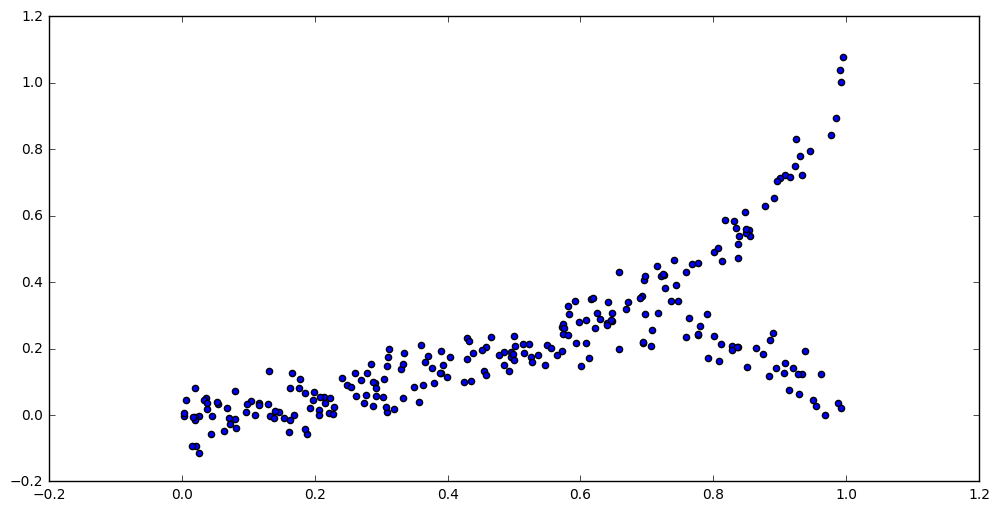

In [3]:
plt.scatter(X, Y);

We define a model assuming `num_clusters` = 2 trends. By default the model will be populated by `num_clusters` RBF kernels. The OMGP implementation is compatible with most kernels in GPflow, so that you for example can encode periodicity in the model.

In [4]:
m = OMGP(X, Y, num_clusters=2, noise_variance=0.01, prior_Z='DP')
m.log_likelihood()

939.34649583176156

A simple plot function is included which illustrates the asignment probability for each data point, it also shows the posterior mean and confidence intervals for each Gaussian Process.

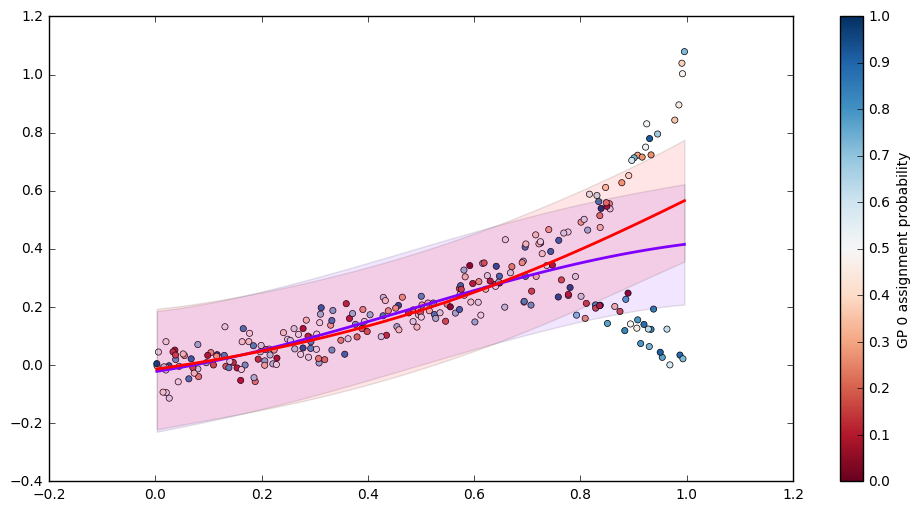

In [5]:
from plotter import OMGPplot
OMGPplot(m,X,Y)

There is also a function for plotting the assignment probability for a given GP directly. Since we haven't optimized the mixture parameters yet the assignment probability is just a random draw from the prior.

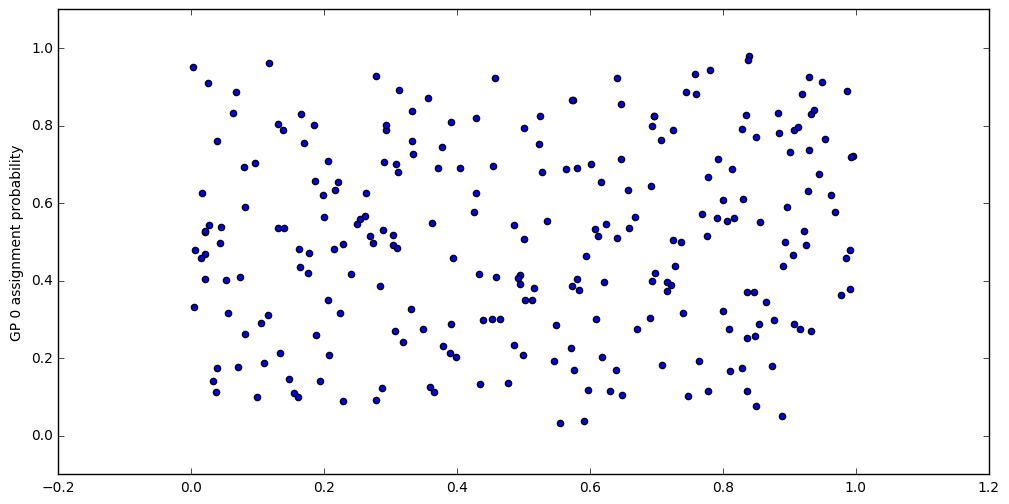

In [6]:
from plotter import OMGPplot_probs
OMGPplot_probs(m, X, gp_num=0)

We can first performa a quick optimization to find the rough trends.

In [7]:
m.optimize(step_length=0.01, maxiter=20)

iteration 1 bound=943.845520223 grad=446.590492609, beta=0
iteration 2 bound=952.773552874 grad=437.672683212, beta=0.975281988555
iteration 3 bound=965.606587882 grad=431.400400988, beta=0.912045908832
iteration 4 bound=979.181999376 grad=441.626150483, beta=0.681147773695
iteration 5 bound=1027.77842458 grad=469.450167707, beta=3.20933148708
iteration 6 bound=1085.3440511 grad=522.084544475, beta=1.98066253006
iteration 7 bound=1088.27737702 grad=301.71098871, beta=0.0
iteration 8 bound=1093.33191078 grad=281.094995228, beta=0.88987863863
iteration 9 bound=1099.07287715 grad=242.765913238, beta=0.795677676185
iteration 10 bound=1104.31822074 grad=195.827532714, beta=0.722433114415
iteration 11 bound=1108.57220606 grad=151.412583821, beta=0.67218938506
iteration 12 bound=1111.87550543 grad=116.032960442, beta=0.648350553172
iteration 13 bound=1114.4663558 grad=89.9824534623, beta=0.651346600035
iteration 14 bound=1116.55437601 grad=70.739794363, beta=0.668843071781
iteration 15 bound=

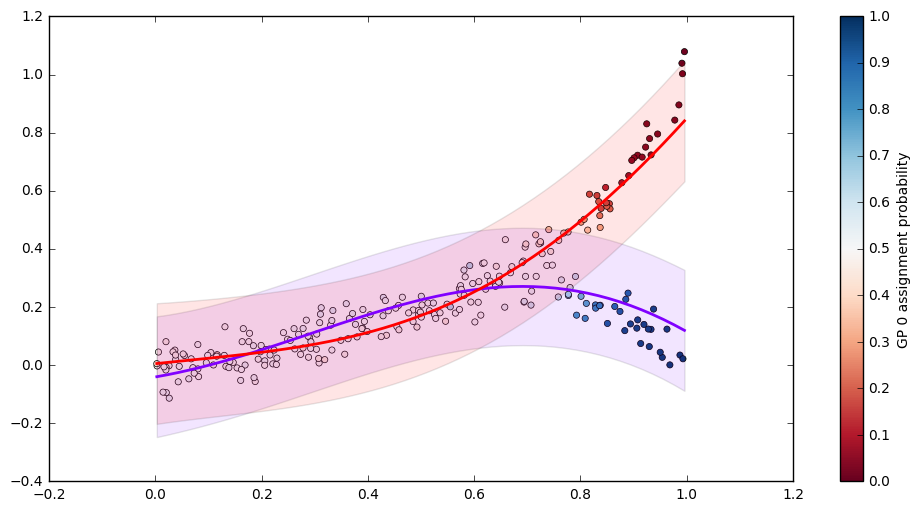

In [8]:
OMGPplot(m,X,Y)

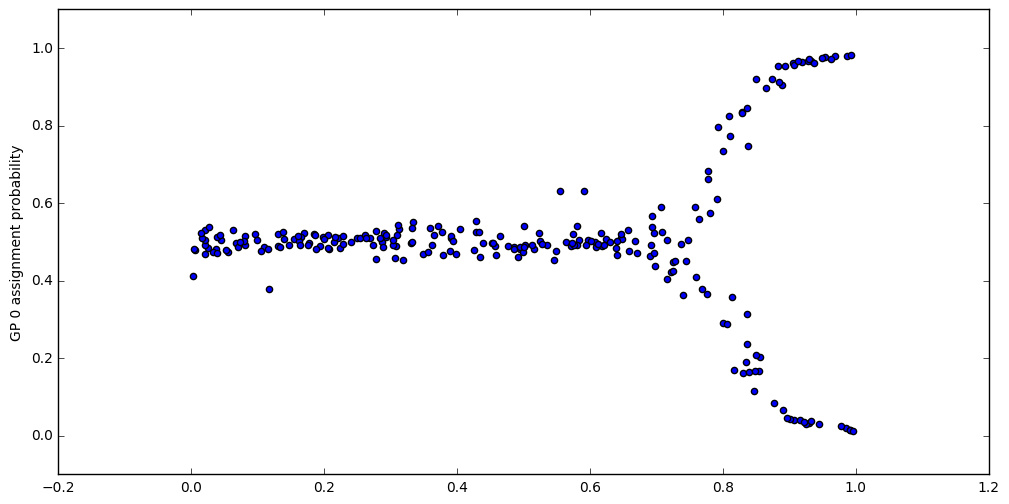

In [10]:
OMGPplot_probs(m,X)

The model identifies the branches of the time series, and in particular the non-branched region have ambigous GP assignment. In this region the two trends share information for prediction.

Like any GPy model the hyper parameters can be inspected.

In [11]:
m

Name,values,prior,constraint
model.noise_variance,[ 0.01],None,+ve
model.kern.item0.lengthscales,[ 1.],None,+ve
model.kern.item0.variance,[ 1.],None,+ve
model.kern.item1.variance,[ 1.],None,+ve
model.kern.item1.lengthscales,[ 1.],None,+ve


We continue by letting the model optimize some more, and also allow it to optimize the hyper parameters. The hyper parameter optimization works best if the mixture parameters have converged or are close to converging.

In [12]:
m.optimize(step_length=0.01, maxiter=200)

iteration 1 bound=1123.49227265 grad=14.3198118515, beta=0
iteration 2 bound=1123.74312836 grad=13.3194996915, beta=0.927590155635
iteration 3 bound=1124.05060442 grad=11.6170496797, beta=0.864521681221
iteration 4 bound=1124.36450276 grad=9.67151592699, beta=0.819904308659
iteration 5 bound=1124.65487483 grad=7.82089044449, beta=0.798686030819
iteration 6 bound=1124.90958844 grad=6.19149657176, beta=0.795677887572
iteration 7 bound=1125.12467679 grad=4.79095063332, beta=0.797012208909
iteration 8 bound=1125.29915406 grad=3.61057395351, beta=0.791801238561
iteration 9 bound=1125.43471334 grad=2.65400253236, beta=0.778765861728
iteration 10 bound=1125.5360433 grad=1.91992538903, beta=0.762431714218
iteration 11 bound=1125.60979179 grad=1.38640033707, beta=0.747377749583
iteration 12 bound=1125.66287387 grad=1.01462572875, beta=0.735591186106
iteration 13 bound=1125.70128438 grad=0.762103788294, beta=0.727568687542
iteration 14 bound=1125.72971413 grad=0.591700166076, beta=0.725695614483

In [13]:
m

Name,values,prior,constraint
model.noise_variance,[ 0.00102702],None,+ve
model.kern.item0.lengthscales,[ 0.22171005],None,+ve
model.kern.item0.variance,[ 0.0186986],None,+ve
model.kern.item1.variance,[ 3.44004864],None,+ve
model.kern.item1.lengthscales,[ 0.55963183],None,+ve


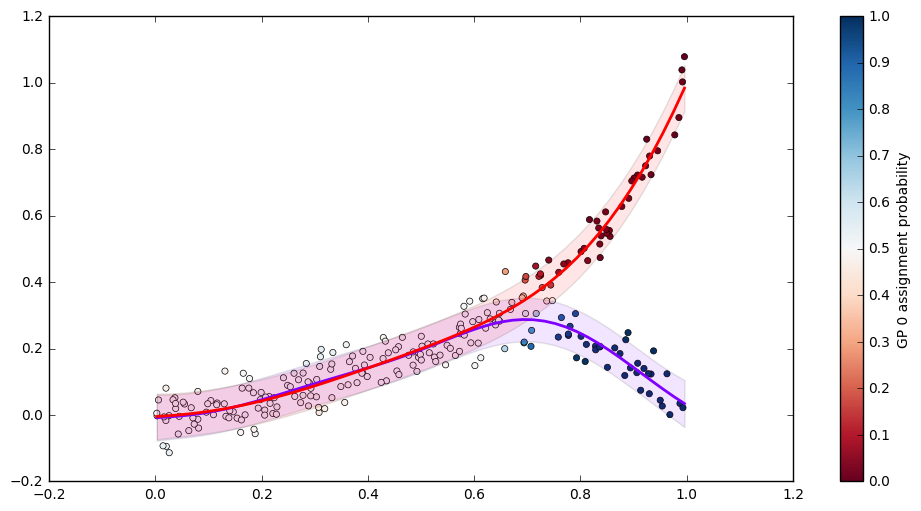

In [14]:
OMGPplot(m,X,Y)

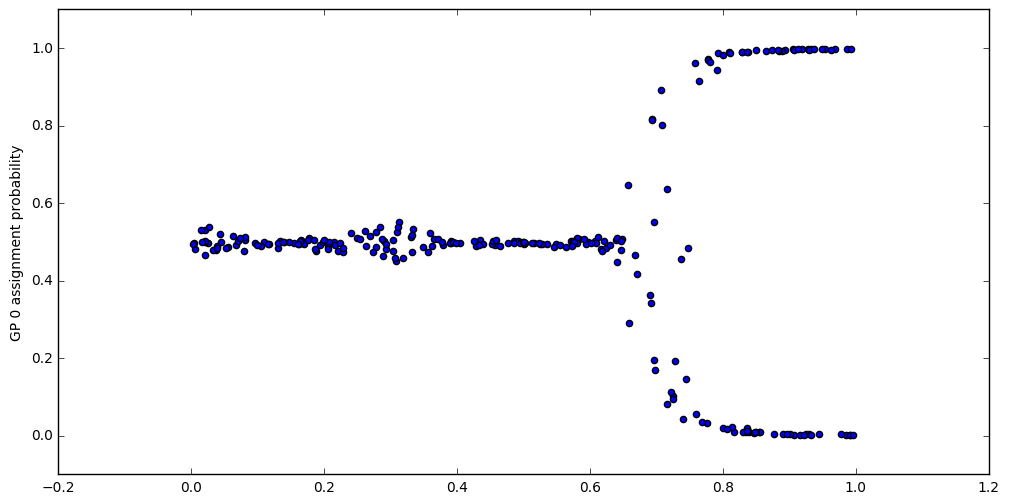

In [15]:
OMGPplot_probs(m,X)

## Separating signal from noise

An interesting application of the OMGP model pointed out in the original publication is the use for robust GP regression.

Let's illustrate this by creating sinusoidal test data with background noise.

In [16]:
x1 = np.random.uniform(0, 10, (100, 1))
x2 = np.random.uniform(0, 10, (100, 1))

y1 = 4 * np.random.randn(*x1.shape)
y2 = 3 * np.sin(x2) + 0.5 * np.random.randn(*x2.shape)
x = np.vstack((x1, x2))
y = np.vstack((y1, y2))

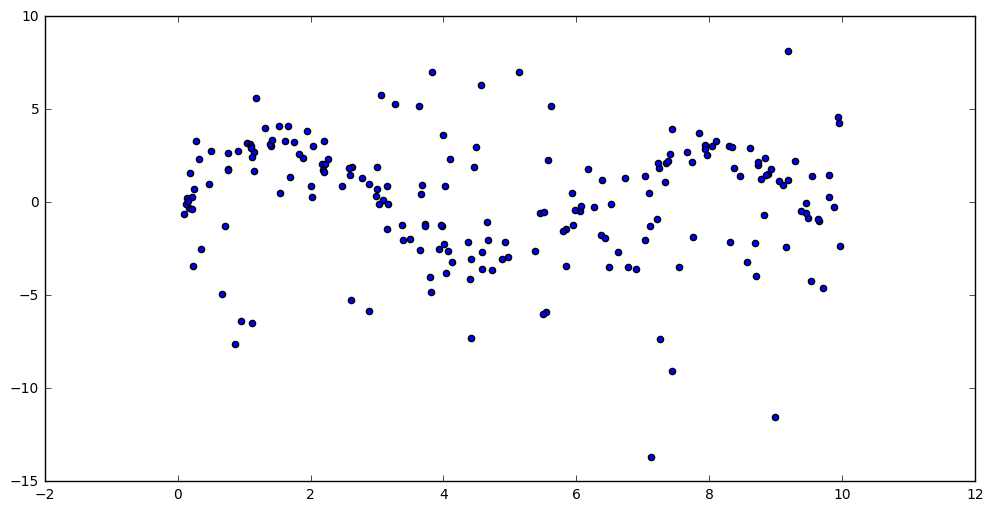

In [17]:
plt.scatter(x, y);

First we make a model with only one mixture component / kernel. This is equivalent to normal GP regression.

In [18]:
kernels = [GPflow.kernels.RBF(1,lengthscales=2.0)]
m = OMGP(x, y, num_clusters=1, prior_Z='DP', kernels=kernels, noise_variance=3.)
m.hyperparam_interval = 100

In [19]:
m.optimize(verbose=False)

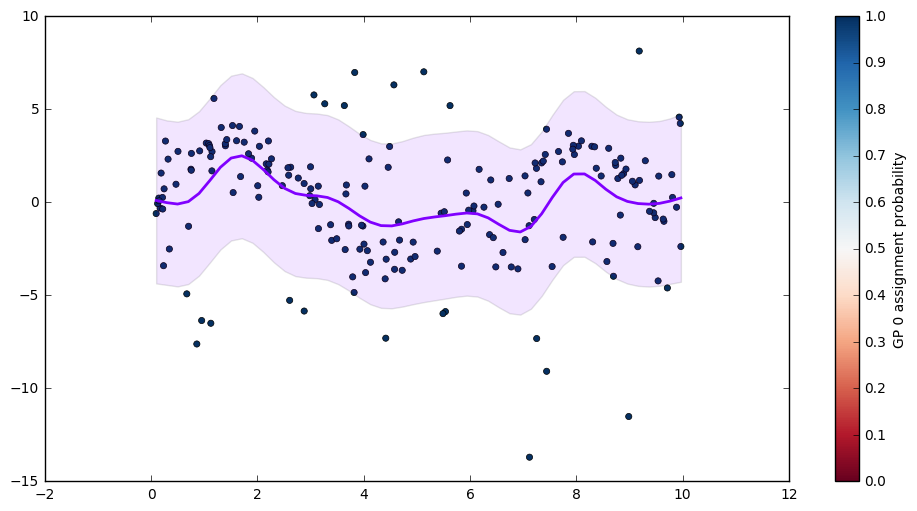

In [20]:
OMGPplot(m,x,y)

Now we in stead view this is a mixture problem, and consider two _different_ kinds of kernels for the different GP components. One encoding white noise, and another which can encode a trend over time (an RBF kernel in this case).

In [21]:
kernels = [GPflow.kernels.White(1), GPflow.kernels.RBF(1, lengthscales=2.0)]
m = OMGP(x, y, num_clusters=2, prior_Z='DP', kernels=kernels, noise_variance=3.)
m.hyperparam_interval = 250

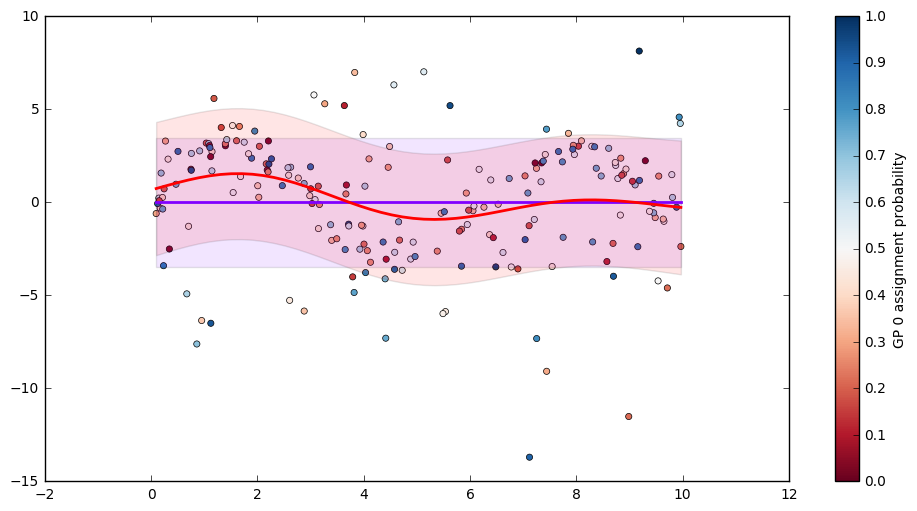

In [22]:
OMGPplot(m,x,y)

In [23]:
m.optimize(step_length=0.01, verbose=False)

In [24]:
m

Name,values,prior,constraint
model.noise_variance,[ 0.31112523],None,+ve
model.kern.item0.variance,[ 10.31688868],None,+ve
model.kern.item1.lengthscales,[ 1.00233662],None,+ve
model.kern.item1.variance,[ 3.21015532],None,+ve


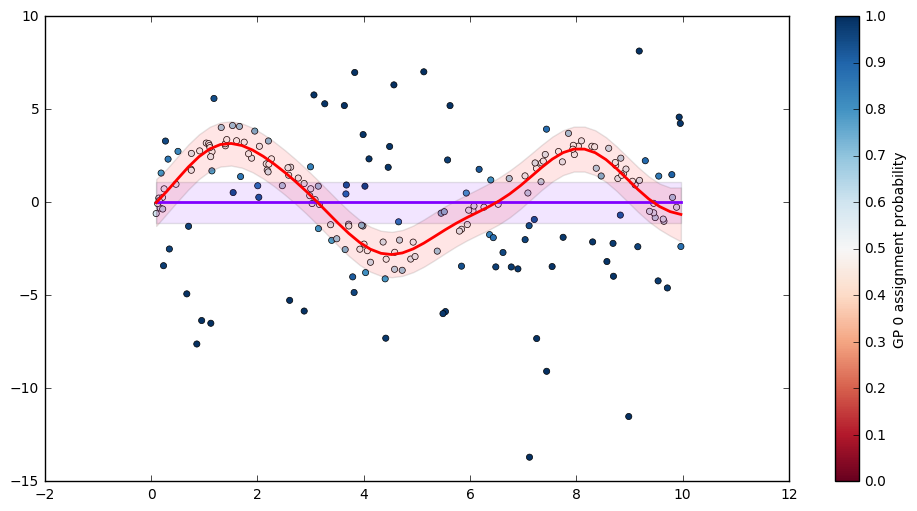

In [25]:
OMGPplot(m,x,y)

The trend over time is much more noticable, and the confidence intervals are smaller.

Noisy points will have high assignment probability to the 'noise GP', while the assignment of the sinusoidal points is ambiguous. We can use this to seperate the points which are more likely to be noise from the remaining points.

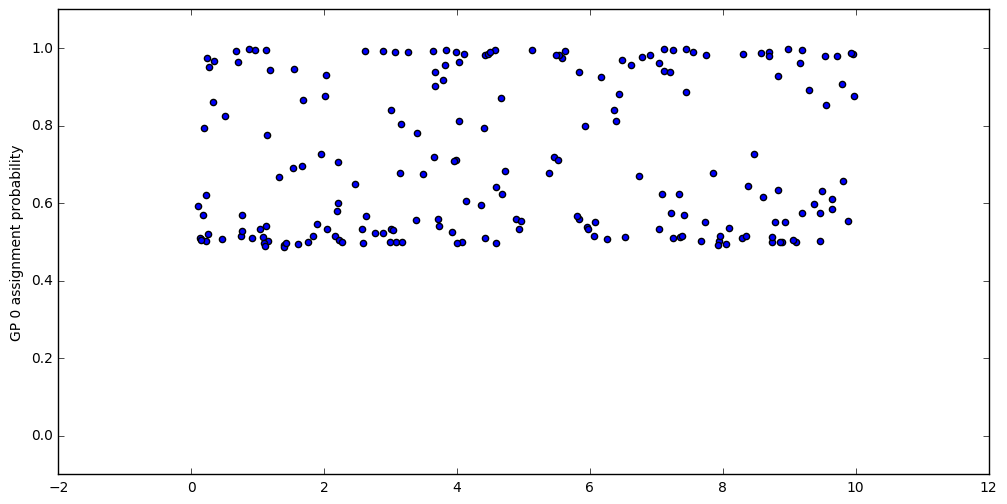

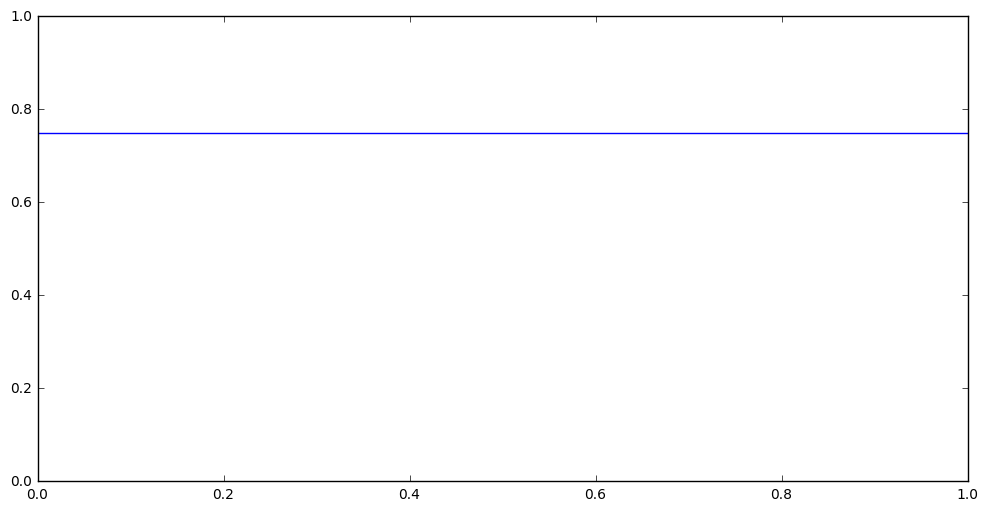

In [26]:
OMGPplot_probs(m,x)
plt.axhline(0.75);

In [27]:
thr = 0.75
phi = m.get_phi()
idx = np.where(phi[:,0] < thr)[0]
nidx = np.where(phi[:,0] >= thr)[0]

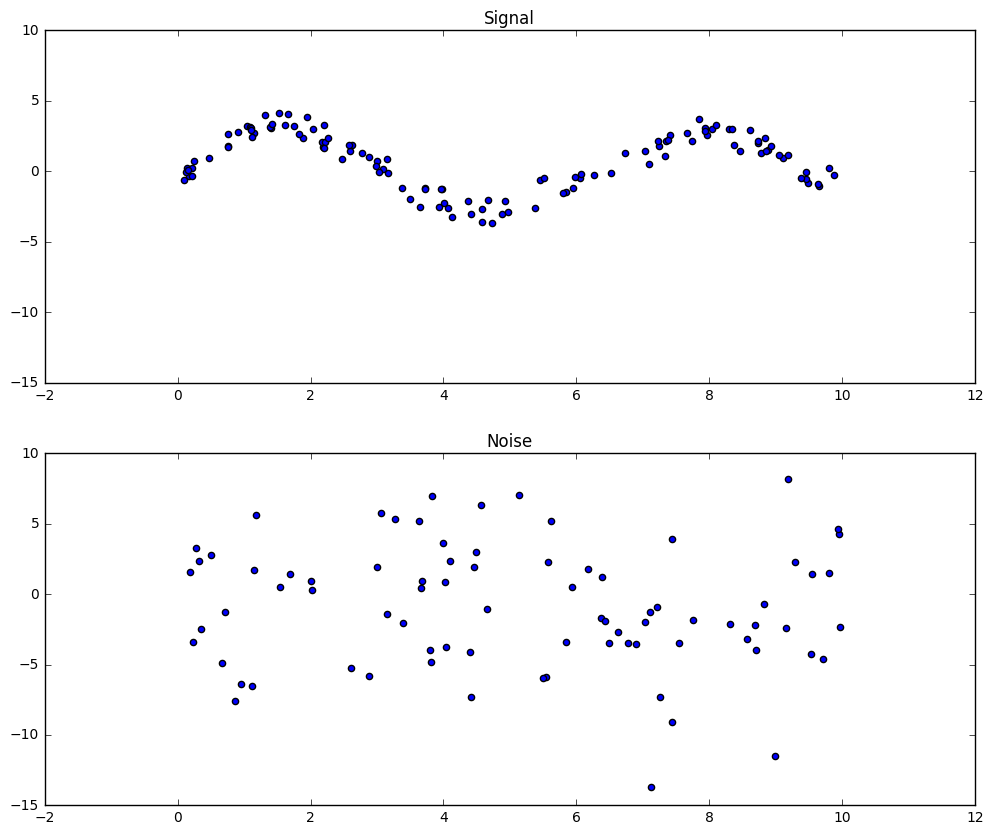

In [28]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.scatter(x[idx], y[idx]);
plt.title('Signal')

plt.subplot(212, sharey=plt.gca())
plt.scatter(x[nidx], y[nidx]);
plt.title('Noise');